In [53]:
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image
import requests
import copy
from PIL import Image, ImageDraw, ImageFont 
import random
import numpy as np
%matplotlib inline  

In [54]:
model_id = 'microsoft/Florence-2-large-ft'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)



In [55]:

def resize_image(input_path, size=(1024, 1024)):
    
    with Image.open(input_path) as img:
       
        img_resized = img.resize(size, Image.LANCZOS)
       
        return img_resized
     

def run_example(task_prompt,image, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer



In [56]:


def convert_to_od_format(data):  
    """  
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.  
  
    Parameters:  
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.  
  
    Returns:  
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.  
    """  
    # Extract bounding boxes and labels  
    bboxes = data.get('bboxes', [])  
    labels = data.get('bboxes_labels', [])  
      
    # Construct the output format  
    od_results = {  
        'bboxes': bboxes,  
        'labels': labels  
    }  
      
    return od_results  



In [57]:


import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show()  



In [58]:
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']

def draw_ocr_bboxes(image, prediction):
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",
        
                    fill=color)
    display(image)



In [88]:
def draw_polygons(image, prediction, fill_mask=False):  
    """  
    Draws segmentation masks with polygons on an image.  
  
    Parameters:  
    - image_path: Path to the image file.  
    - prediction: Dictionary containing 'polygons' and 'labels' keys.  
                  'polygons' is a list of lists, each containing vertices of a polygon.  
                  'labels' is a list of labels corresponding to each polygon.  
    - fill_mask: Boolean indicating whether to fill the polygons with color.  
    """  
    # Load the image  
   
    draw = ImageDraw.Draw(image)  
      
   
    # Set up scale factor if needed (use 1 if not scaling)  
    scale = 1  
      
    # Iterate over polygons and labels  
    for polygons, label in zip(prediction['polygons'], prediction['labels']):  
        color = random.choice(colormap)  
        fill_color = random.choice(colormap) if fill_mask else None  
          
        for _polygon in polygons:  
            _polygon = np.array(_polygon).reshape(-1, 2)  
            if len(_polygon) < 3:  
                print('Invalid polygon:', _polygon)  
                continue  
              
            _polygon = (_polygon * scale).reshape(-1).tolist()  
              
            # Draw the polygon  
            if fill_mask:  
                draw.polygon(_polygon, outline=color, fill=fill_color)  
            else:  
                draw.polygon(_polygon, outline=color)  
              
            # Draw the label text  
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)  
  
    # Save or display the image  
    #image.show()  # Display the image  
    display(image)

In [154]:
image = resize_image('/home/sma/sqdc/labelTest.jpg')
#image = image.convert('RGB')




In [155]:

task_prompt = '<MORE_DETAILED_CAPTION>'
run_example(task_prompt,image=image)

{'<MORE_DETAILED_CAPTION>': 'A brown cardboard box with a white label on it. The label has black writing on it and a barcode under it. There is a white sticker on the top of the box.'}

{'<OCR_WITH_REGION>': {'quad_boxes': [[720.384033203125, 189.95201110839844, 800.2560424804688, 189.95201110839844, 800.2560424804688, 216.5760040283203, 720.384033203125, 216.5760040283203], [709.1200561523438, 231.93600463867188, 824.83203125, 231.93600463867188, 824.83203125, 256.51202392578125, 709.1200561523438, 256.51202392578125], [443.9040222167969, 348.6720275878906, 551.4240112304688, 350.72003173828125, 551.4240112304688, 386.5600280761719, 443.9040222167969, 384.51202392578125], [696.83203125, 419.3280334472656, 798.2080078125, 420.3520202636719, 798.2080078125, 446.97601318359375, 696.83203125, 445.9520263671875], [628.2240600585938, 552.447998046875, 838.14404296875, 555.52001953125, 838.14404296875, 581.1200561523438, 628.2240600585938, 577.0240478515625], [727.5520629882812, 581.1200561523438, 837.1200561523438, 583.1680297851562, 837.1200561523438, 608.7680053710938, 727.5520629882812, 605.696044921875], [628.2240600585938, 605.696044921875, 766.4640502929688, 607.7440

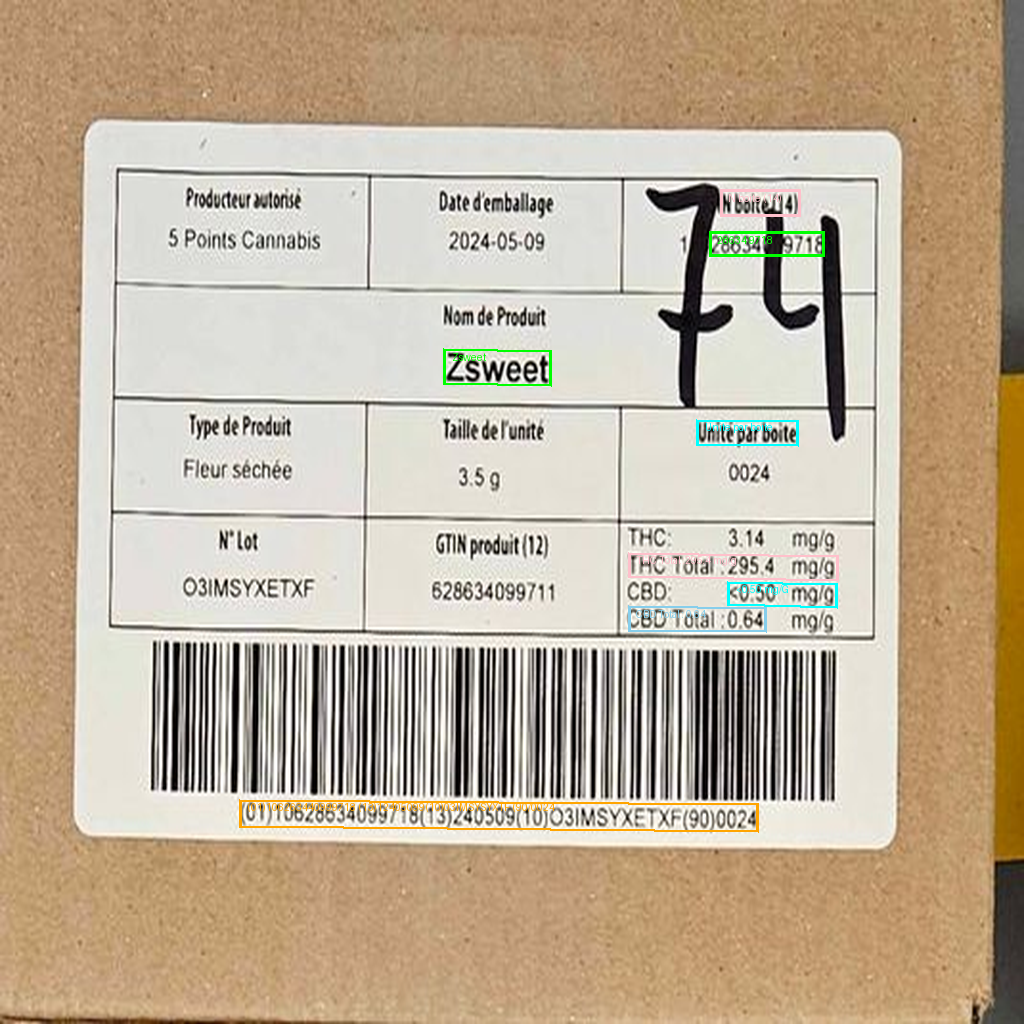

In [156]:


task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt,image=image)
print(results)
output_image = copy.deepcopy(image)
draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>']) 

{'<DENSE_REGION_CAPTION>': {'bboxes': [[0.5120000243186951, 0.5120000243186951, 1022.4640502929688, 1022.4640502929688]], 'labels': ['cannabis product label']}}


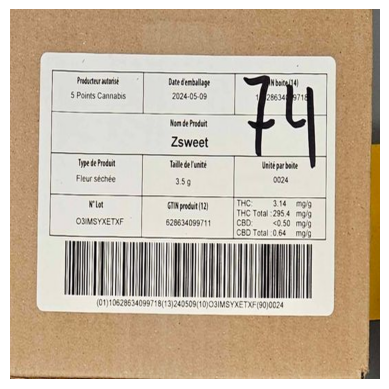

In [157]:
prompt = "<DENSE_REGION_CAPTION>"
results = run_example(prompt,image=image)
print(results)
bbox_results  = convert_to_od_format(results['<DENSE_REGION_CAPTION>'])

plot_bbox(image, bbox_results)

{'<OD>': {'bboxes': [[0.5120000243186951, 0.5120000243186951, 1022.4640502929688, 1022.4640502929688]], 'labels': ['box']}}


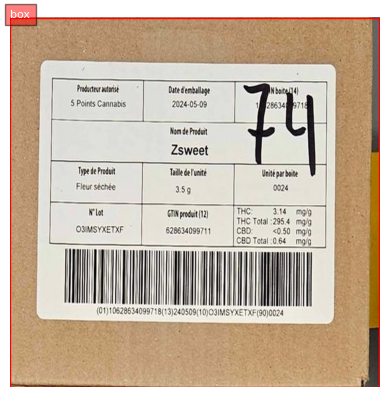

In [158]:


task_prompt = '<OD>'
results = run_example(task_prompt,image=image)
print(results)

plot_bbox(image, results['<OD>'])

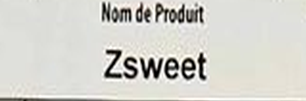

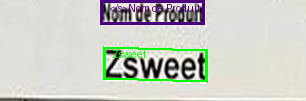

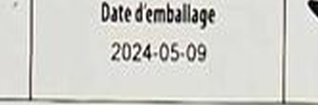

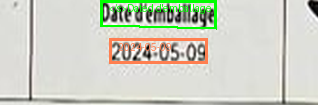

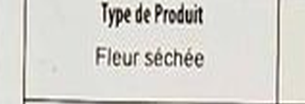

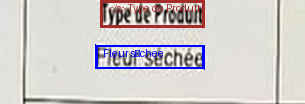

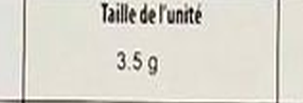

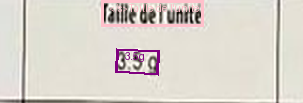

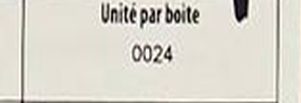

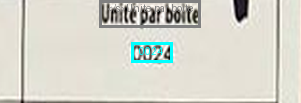

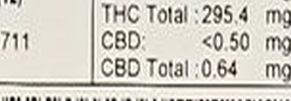

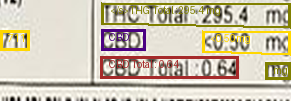

['</s>Nom de Produit', 'Zsweet']
["</s>Dated d'emballage", '2024-05-09']
['</s>Type de Produit', 'Fleur séchee']
["</s>Taille de l'unite", '3.5g']
['</s>Unite par boite', '0024']
['</s>THG Total :295.4 mg', '711', 'CBD:', '<0.50mg', 'CBD Total : 0.64', 'mg']


In [167]:




def draw_polygons2(img, data):
    draw = ImageDraw.Draw(img)
    
    # Draw each polygon
    for polygon_list, label in zip(data['<OPEN_VOCABULARY_DETECTION>']['polygons'], data['<OPEN_VOCABULARY_DETECTION>']['polygons_labels']):
        for polygon in polygon_list:
            # Convert the flat list of coordinates to a list of tuples
            polygon_points = [(polygon[i], polygon[i + 1]) for i in range(0, len(polygon), 2)]
            # Draw the polygon
            draw.polygon(polygon_points, outline="red")
            # Optionally, draw the label
            draw.text(polygon_points[0], label, fill="red")
    
    # Display the image
    display(img)



def crop_to_number(img, data):
    
    
    # Get the polygon coordinates
    polygon = data['<OPEN_VOCABULARY_DETECTION>']['polygons'][0][0]  # Assuming a single polygon

    # Define the bounding box
    min_x = min(polygon[0::2])-100
    max_x = max(polygon[0::2])+100
    min_y = min(polygon[1::2])
    max_y = max(polygon[1::2])
    
    # Adjust the bounding box to include the area below the label
    # Adjusting height to include the number below the label
    extended_max_y = max_y + 75  # Adjust this value based on your specific image
    
    return img.crop((min_x, min_y, max_x, extended_max_y))

def extract_important_data(image, data_labels):
    extracted_data = []

    for label in data_labels:
        # Run the object detection model to find the relevant area
        results = run_example('<OPEN_VOCABULARY_DETECTION>', image=image, text_input=label)
        
        # Copy the image to crop it
        output_image = copy.deepcopy(image)
        
        # Crop the image to the relevant area
        cropped_img = crop_to_number(output_image, results)
        
        # Display the cropped image (optional)
        display(cropped_img)
        
        # Perform OCR on the cropped image
        results2 = run_example('<OCR_WITH_REGION>', image=cropped_img)
        draw_ocr_bboxes(cropped_img,results2['<OCR_WITH_REGION>'])

        # Extract the text from OCR results and append to the list
        extracted_text = results2['<OCR_WITH_REGION>']['labels']
        extracted_data.append((label, extracted_text))
    
    return extracted_data

Important_data = ['Nom de Produit',"Date d'emballage",'Type de Produit',"Taille de l'unité","Unité par boite","THC Total"]

# Extract important data from the image
important_data_extracted = extract_important_data(image, Important_data)

# Print the results
for label, text in important_data_extracted:
    print(f"{text}")
